# EM Algorithm From Scratch

I will  implement the EM algorithm on the school information dataset (with the assist of PCA).

##### The dataset:
I will use real student data recorded from Cogs. Sci. students. We have removed sensitive information such as student PID and names.

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

data = pd.read_csv('PA2_data.csv')
data.head()

,ID,number of subjects learned,How comfortable are you with programming?,How comfortable are you with statistics?,programming lanuages,total_points,Final Project,hw time sum
0,002_wi20,4,6,5,1,97.95,21.75,14.0
1,005_wi20,1,6,6,0,101.15,23.50,35.0
2,007_wi20,5,10,8,1,97.48,24.50,6.5
3,011_wi20,2,7,3,0,95.72,22.00,37.0
4,014_wi20,2,4,7,0,98.70,23.25,48.0


In [3]:
X = data.to_numpy()

X = X[:,1:].astype(float)
X = X/X.max(axis=0)           # scaling the values to [0,1] range. We can divide by the max value of each column because we do not have negative values in the data.
print('Shape of X: ', X.shape)

Shape of X:  (181, 7)


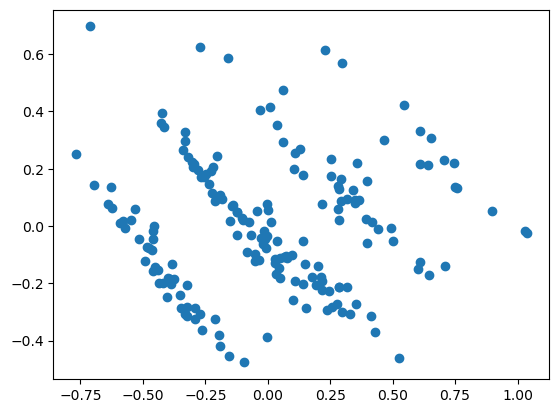

In [4]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:,0], X_pca[:, 1])

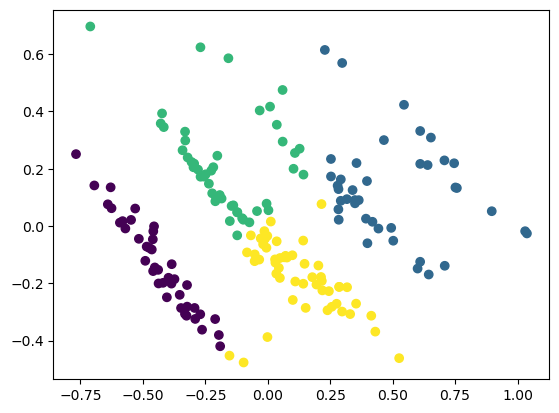

In [5]:
from sklearn.cluster import KMeans

labels = KMeans(n_clusters = 4).fit_predict(X_pca)
plt.scatter(X_pca[:,0], X_pca[:, 1], c = labels)

**CODE EXPLANATION**: The code here focuses on creating a KMeans clustering model that will be divided into 4 clusters (k = 4) and then uses the fit_predict() function in order to fit the KMeans model to the dataset of X_pca, which is the data we have after using PCA to reduce the dimensions of the data. Then, this model assigns each data point to the cluster that it is closest to and then leads to labels that is an array of cluster labels {from values 0, 1, 2, 3} because we have 4 clusters. Finally, we plot the first two PCA components on the x and y axis and use the labels created from the fit_predict(X_pca) in order to color what points belong to which cluster. 

# PART 2 - EM

EM Algorithm finds clusters by treating each cluster as a 2D Gaussian distribution, and then fits the parameters of each distribution to accurately model the data. The goal is to find the optimal parameters for each of the Gaussians that model the data accurately.

In [6]:
class EMModel:
    
    def __init__(self, X, k, max_iters):
        """
        This function initializes our parameters (mu, pi, and sigma) and plots our data points.
        """
        self.X = X # N x 2 matrix containing all of our data pts
        self.k = k # number of clusters; in our case, k = 4
        self.max_iters = max_iters # in our case, max_iters = 500 
        
        self.dim = self.X.shape[1] # Equals 2, as we are considering 2D points
        self.N = self.X.shape[0] # Equals the number of points in the dataset, N = 181
        
        """
        Here we initialize mu, pi, and sigma. Mu is k X 2, Pi is k X 1, Sigma is k X 2 X 2
        """
        # initialize mu (k x 2)
        random_indexes = np.random.choice(self.N, self.k, replace = False) # randomly select k indices 
        self.mu = self.X[random_indexes]   # mu = k x 2, where from our data matrix X, we are randomly selecting k number of data points

        # initialize pi (k x 1), fills each entry with 1/k for each cluster
        self.pi =  np.full(shape = (self.k, 1), fill_value = (1.0/self.k)) 

        # initialize sigma (k x 2 x 2) with diag vals of 5
        self.sigma = np.array([np.diag([5.0] * self.dim) for i in range(self.k)]) 
            
        """
        This part is required to plot clusters
        """
        x,y = np.meshgrid(np.sort(self.X[:,0]),np.sort(self.X[:,1]))
        self.XY = np.array([x.flatten(),y.flatten()]).T
            
        """
        Finally, let's visualize our data points
        """
        self.plot_data('Initial State')

In [7]:
from scipy.stats import multivariate_normal

def plot_data(self, title, colors=None):
    """
    This function creates a scatter plot of all the data points. It also creates a contour plot of the probability 
    distributions of each of the clusters (specified by mu, pi, and sigma)
    """
    fig = plt.figure(figsize=(6,6))
    ax0 = fig.add_subplot(111)
    ax0.scatter(self.X[:,0], self.X[:,1], c=colors)
    ax0.set_title(title)
    for m,c in zip(self.mu,self.sigma):
        multi_normal = multivariate_normal(mean=m,cov=c)
        ax0.contour(np.sort(self.X[:,0]),np.sort(self.X[:,1]),multi_normal.pdf(self.XY).reshape(len(self.X),len(self.X)),colors='black',alpha=0.3)
        ax0.scatter(m[0],m[1],c='grey',zorder=10,s=100)
        
EMModel.plot_data = plot_data

mu shape: (4, 2)
pi shape: (4, 1)
sigma shape: (4, 2, 2)
mu:
 [[-0.19595756 -0.38054803]
 [ 0.28398833  0.02176804]
 [ 0.10301595  0.19973898]
 [-0.21003865  0.08630786]]
pi:
 [[0.25]
 [0.25]
 [0.25]
 [0.25]]
sigma:
 [[[5. 0.]
  [0. 5.]]

 [[5. 0.]
  [0. 5.]]

 [[5. 0.]
  [0. 5.]]

 [[5. 0.]
  [0. 5.]]]


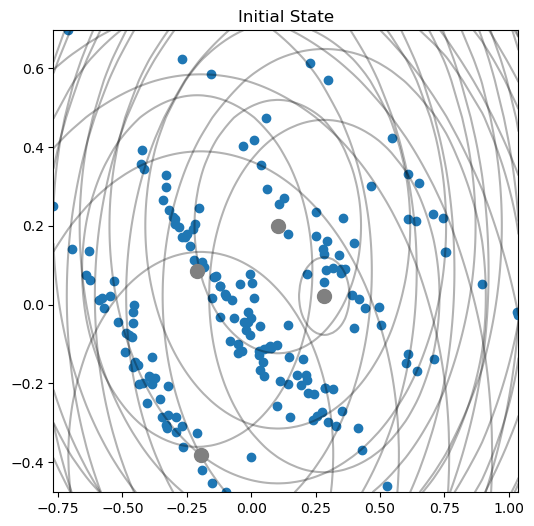

In [8]:
import numpy as np

# create model (just initializes + plots)
model = EMModel(X_pca, k=4, max_iters=500)

# check shapes and values
print("mu shape:", model.mu.shape)       # (4, 2)
print("pi shape:", model.pi.shape)       # (4, 1)
print("sigma shape:", model.sigma.shape) # (4, 2, 2)

print("mu:\n", model.mu)
print("pi:\n", model.pi)
print("sigma:\n", model.sigma)

Now we define our `expectation` function. This function's job is to compute $r_{ic}$, which is the probability that point $i$ belongs to cluster $c$. ($0 \leq i < N$, $0 \leq c < k$)

We will store $r_{ic}$ as a matrix of size $N \times k$. (as we have to store the probability of every point for each cluster).

$r_{ic}$ is computed as follows:
<img src="ric.png">

To compute it, we basically:
- compute its probability under cluster model $c$
- normalize it to sum to 1 using its probabilities from all the clusters

Finally, we should return `r` after computing it.

**To-do:** (2.2)  (10 points)

Complete the `expectation` method. (5 points)

In [9]:
# best one
def expectation(self):
    """ 
    - compute responsibilities (probability that each data point belongs to each cluster)
    - returning r, an array of shape (N,K), where row sums to 1
    """
    # r = table of responsibilities 
    data, num_pts, num_clusters = self.X, self.N, self.k
    r = np.zeros((num_pts, num_clusters)) # (N,K) = (num pts, num clusters) 
    
    # 1. compute numerator = prior prob * likelihood for each cluster c (pdf)
    for cluster_index in range(num_clusters):
        cluster_gauss = multivariate_normal(mean = self.mu[cluster_index], cov = self.sigma[cluster_index]) 
        all_pts_pdf_vals = cluster_gauss.pdf(data) # PDF values for all points under cluster k,  f(x_i | mu_k, Sigma_k)
        r[:, cluster_index] = self.pi[cluster_index ,0] * all_pts_pdf_vals  # weighted likelihood (prior * likelihood)
    
    # 2. compute normalizing constants (denom = sum across clusters for each point = p(x_i))
    point_total = r.sum(axis=1)[:, np.newaxis]

    # 3. normalize to turn vals into probabilities
    r = r / point_total 
    
    return r
    
EMModel.expectation = expectation

**CODE EXPLANATION:** For this code, it serves as the expectation function for our E-step in the EM algorithm--where it calculats the responsibilities, also known as the probability that each data point belongs to each cluster. For how it works, the function intializes an empty responsibility matrix (r) that has the shape of (self.N,self.k)--where N is the number of points and k is the number of clusters. Then, for every cluster, we find the Gaussian distribution using the stated cluster mean and covariance and then compute what is the probability density (PDF values) for all of the data points. This represents how much the cluster represents th eoverall dataset and how much it represents each point. After we are done looping all of the clusters, we normalize the responsibilities for each data point by dividng the total probability for that point, since we need to make sure that every row sum is equal to 1. Finally, we have a resulting responsibility matrix (r) that represents the probability that a given data point is assigned to a specific cluster.

In [10]:
def maximization(self, r):
    
    data, num_clusters, num_pts, num_dim = self.X, self.k, self.N, self.dim
    
    Nk = np.sum(r, axis = 0)                                 # Nk = soft counts per cluster (sum of responsibilities)
    means = np.zeros((num_clusters, num_dim))                # new means
    covariances = np.zeros((num_clusters, num_dim, num_dim)) # new covariances
    cluster_weights = np.zeros(num_clusters)                 # new prior probabilities for each cluster
    
    for k in range(num_clusters): 
        # 1. compute/update weight for cluster k: pi_k = Nk / N
        cluster_weights[k] = Nk[k] / num_pts

        # 2. compute/update mean for cluster k: mu_k = (sum_i r_ik + x_i) / Nk
        weighted_sum = 0.0
        for i in range(num_pts):
            weighted_sum = weighted_sum + (r[i,k] * data[i])
        means[k] = weighted_sum / Nk[k]
        
        # 3. compute/update covariances for cluster k: (sum_i r_ik (x_i-μ_k)(x_i-μ_k)^T) / Nk
        weighted_sum = np.zeros((num_dim, num_dim))
        for i in range(num_pts):
            diff = data[i] - means[k]
            weighted_sum = weighted_sum + r[i,k] * np.outer(diff, diff)
        covariances[k] = weighted_sum / Nk[k]
    
    # update model parameters
    self.mu = means
    self.sigma = covariances
    self.pi = cluster_weights.reshape(num_clusters, 1)
    
    return means, covariances, cluster_weights
    
EMModel.maximization = maximization

**CODE EXPLANATION:** Now, this code implements the M-step (maximization step) in EM algorithm--where given our current responsibilities (weighted probabilities of how much each cluster "represents" each data point), we will update the model parameters (cluster weights, means, and covariances) to the "best" parameters, or maximizing the parameters to the best values that represent the data.
- We start off by calculating Nk, also known as the "soft counts", which is the sum of responsibilities from all data points for each cluster.
- Then in our for each cluster, we:
    1. We calculate the *cluster weights*, which are the prior probabilities for each cluster and computed as Nk/N.
    2. We calculate and update the weighted means (mu_k)--where we update the mean as the weighted average for all points and the we shift the cluster center towards data points it is most responsible for.
    3. We calculate and update the weighted covariances--where we update the covariance matrix by computing the weighed outer product for each point;s deviation to caputre the spread/shape of the cluster.
- Then, because we are intializing the EMModel as a Class, we need to update the model paramteters of self.mu, self.sigma, self.pi.

In [11]:
def run(self):
    for i in range(self.max_iters):
        r = self.expectation()      # E-step
        self.maximization(r)        # M-step
    
    color_labels = np.argmax(self.expectation(), axis=1)
    self.plot_data('Final State', color_labels)

EMModel.run = run

**CODE EXPLANATION**: This run function runs the expectation and maximization functions we have by looping for the specified number of iterations (max iters). We begin with exepctation step--where it computes the repsonsibilities that represent the probability of each data point for each cluster and the maximization step, where it updates the parameters of the model using the responsibilities. Finally, this process rpepats until the iterations complete and the function has its final cluster assignment that will be displayed as a plot.

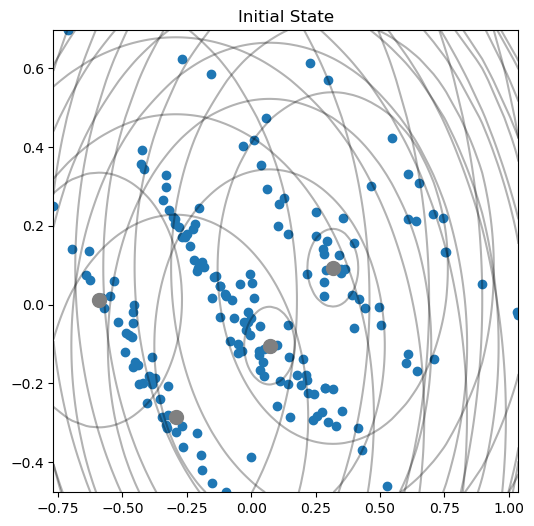

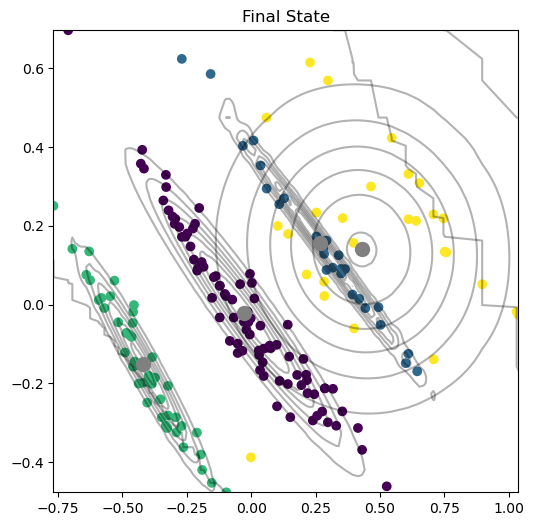

In [12]:
model = EMModel(X_pca, k = 4, max_iters = 500)

model.run()

### Hierarchical Clustering

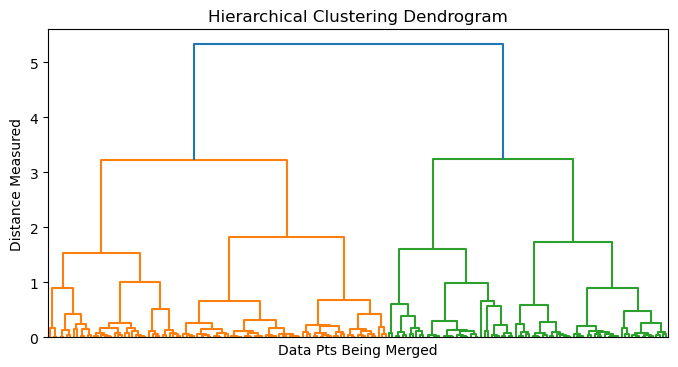

In [13]:
from scipy.cluster.hierarchy import linkage, dendrogram 

Z = linkage(X_pca, method="ward")  

plt.figure(figsize=(8, 4))
dendrogram(Z, no_labels=True)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Data Pts Being Merged")
plt.ylabel("Distance Measured")
plt.show()